# Deploy HuggingFaceTB/SmolLM3-3B for inference using Amazon SageMakerAI

**IMPORTANT**: Make sure you've read the instructions in the [README.md](..) file before proceeding with the content of this notebook!

This notebook demonstrates how to deploy and use the SmolLM3 3B model on Amazon SageMaker AI. SmolLM3 is a 3B parameter language model designed to push the boundaries of small models. It supports 6 languages, advanced reasoning and long context. SmolLM3 is a fully open model that offers strong performance at the 3B–4B scale.

The model is a decoder-only transformer using GQA and NoPE (with 3:1 ratio), it was pretrained on 11.2T tokens with a staged curriculum of web, code, math and reasoning data. Post-training included midtraining on 140B reasoning tokens followed by supervised fine-tuning and alignment via Anchored Preference Optimization (APO).

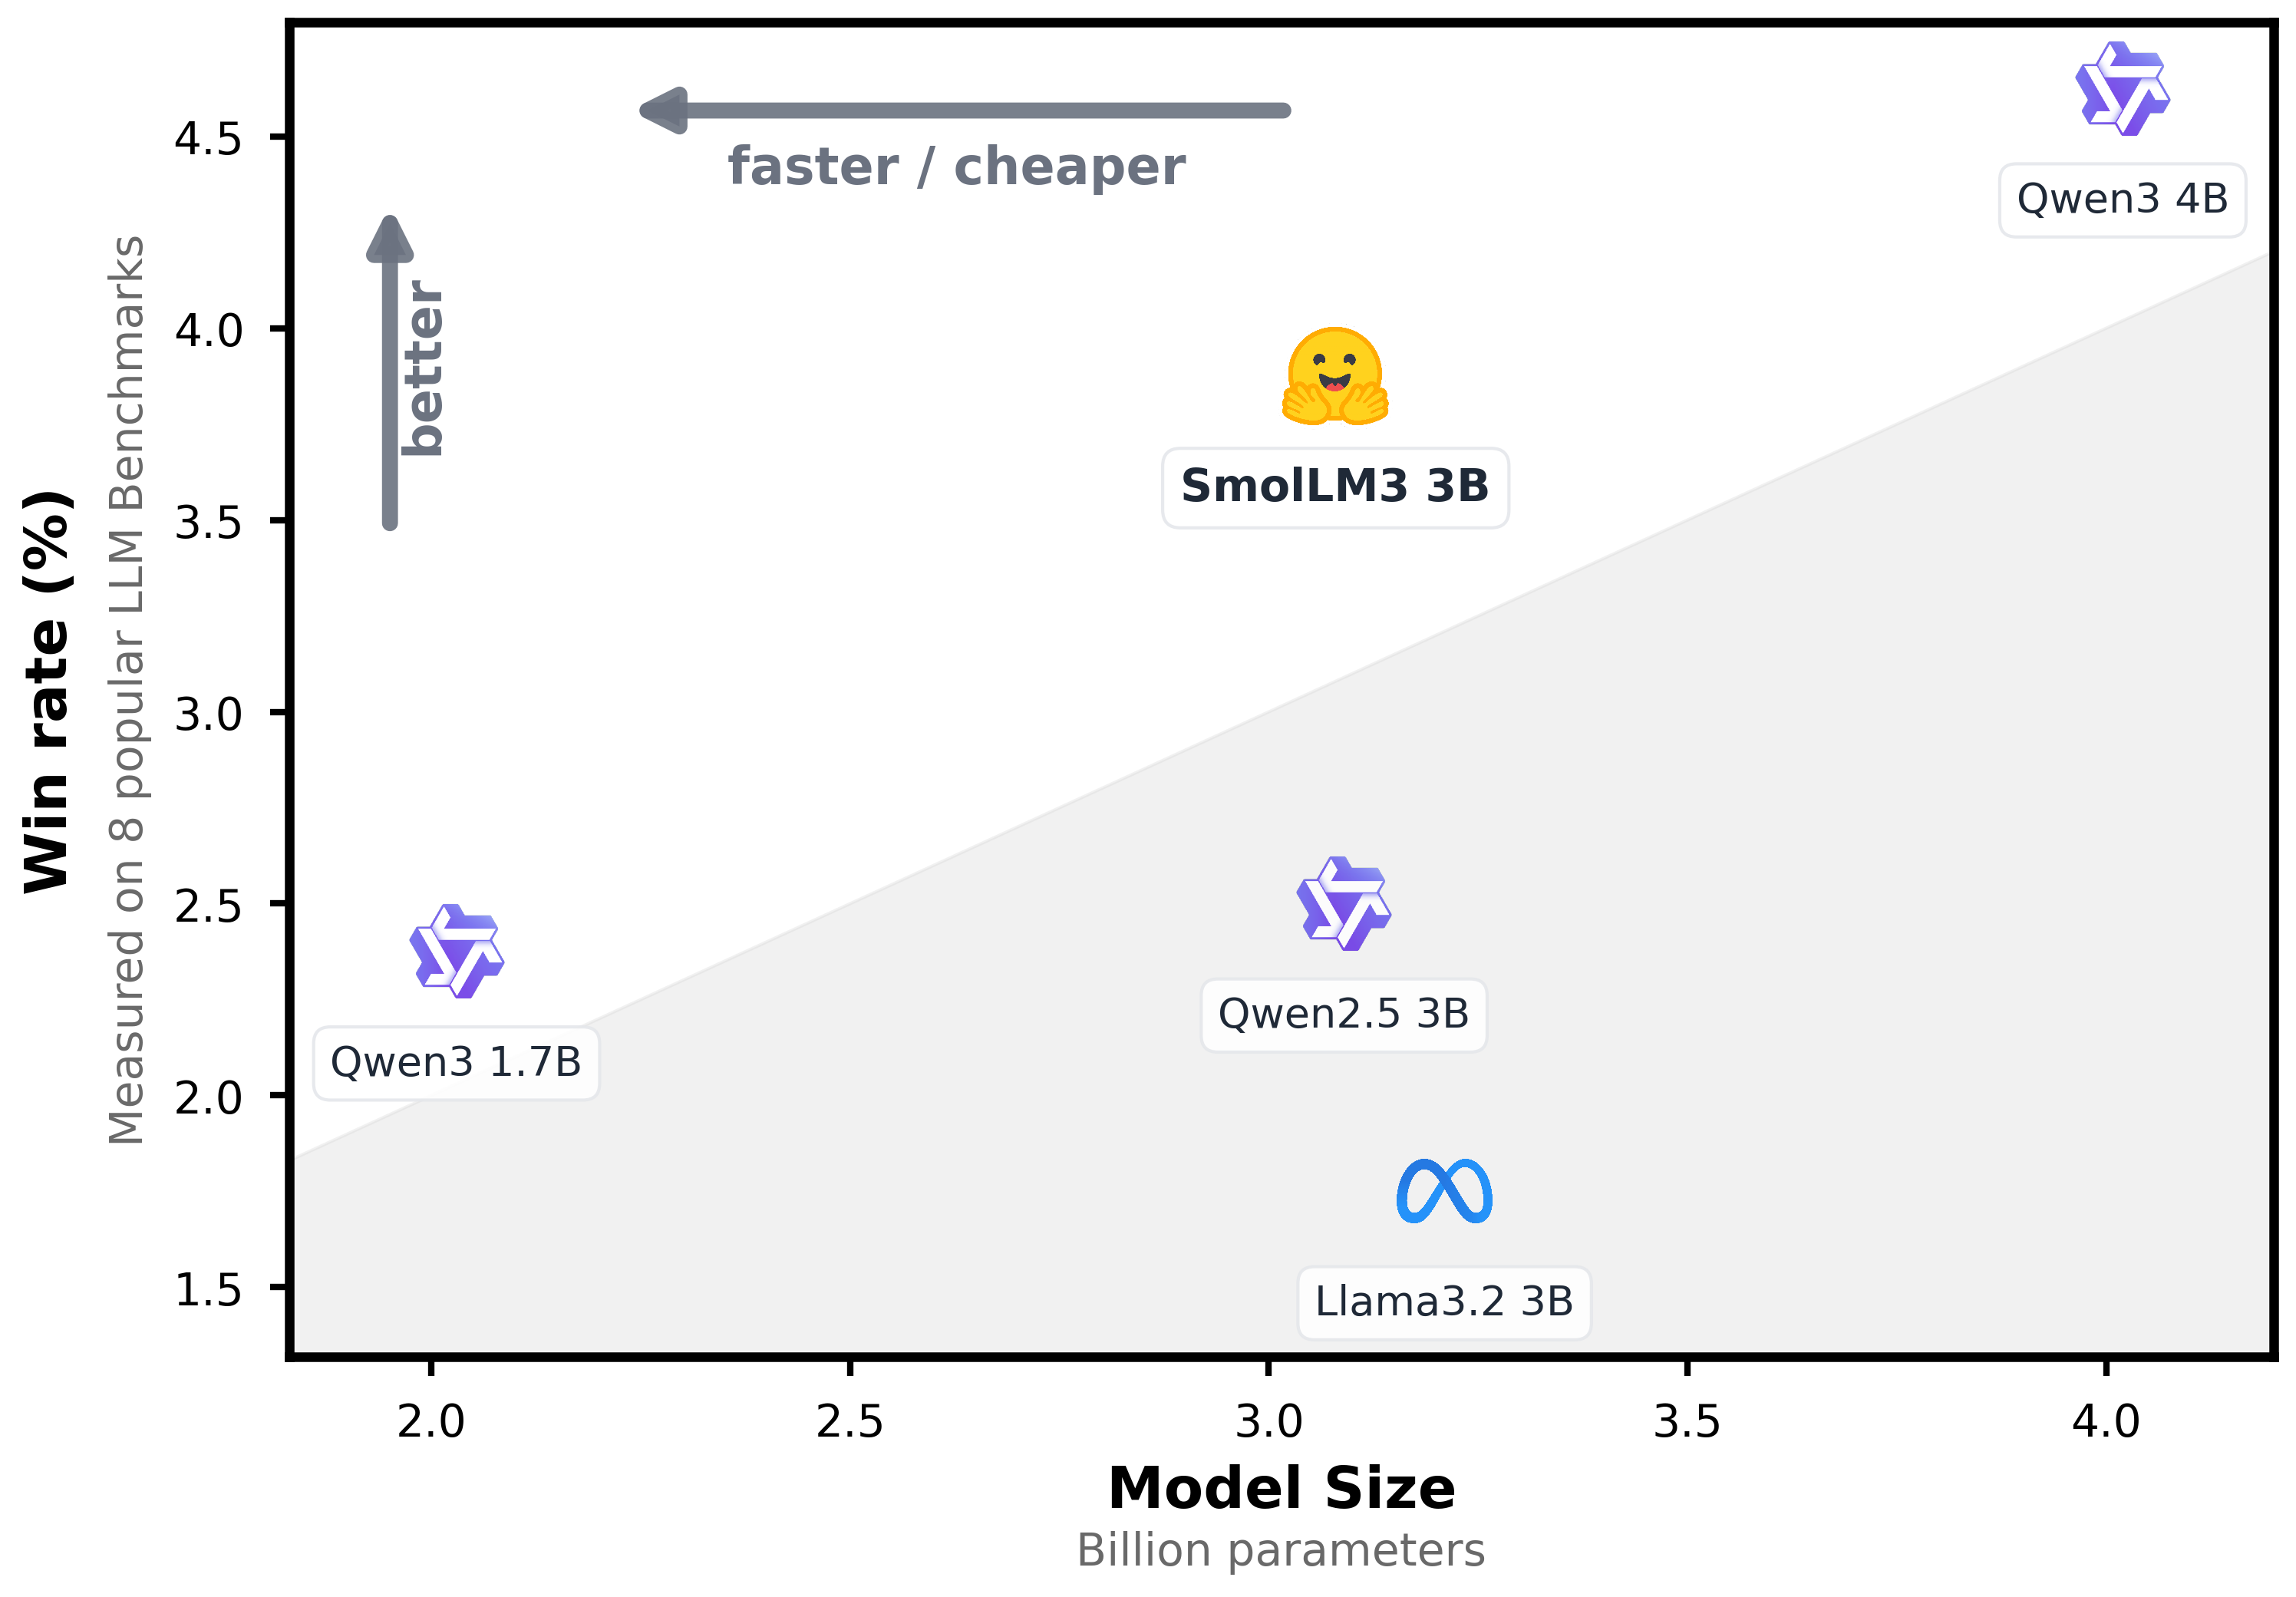

In [ ]:
%pip install sagemaker -qU

In [ ]:
from sagemaker.djl_inference import DJLModel
from sagemaker.session import Session
from sagemaker.utils import name_from_base
from sagemaker import get_execution_role
import boto3
import re


# Configure IAM permissions
try:
    role = get_execution_role()
except:
    role = input("Enter your SageMaker role ARN: ")

##### PARAMS TO CONFIGURE #####
model_id = "HuggingFaceTB/SmolLM3-3B"
region_name = "us-east-1"
image_name_and_tag = input("> Provide the name of your image like this - image:tag")
###############################

clean_model_id = re.sub(r'[^a-zA-Z0-9]', '-', model_id.split("/")[-1])
model_name = name_from_base(clean_model_id)
endpoint_name = name_from_base(clean_model_id+"-ep")

boto_session = boto3.Session(region_name=region_name)
session = Session(boto_session=boto_session)
account_id = boto_session.client("sts").get_caller_identity()["Account"]

model = DJLModel(
    name=model_name, role=role, sagemaker_session=session,
	image_uri=f"{account_id}.dkr.ecr.{region_name}.amazonaws.com/{image_name_and_tag}",
    env={
        "HF_MODEL_ID": model_id,
        "OPTION_MAX_MODEL_LEN": f"{1024*16}",
        # "OPTION_QUANTIZE": "fp8",
        "OPTION_ROLLING_BATCH": "vllm",
        "OPTION_ENABLE_AUTO_TOOL_CHOICE": "true",
        "OPTION_TOOL_CALL_PARSER": "hermes",
    },
)

# deploy model to SageMaker Inference
predictor = model.deploy(
	initial_instance_count=1,
	instance_type="ml.g5.2xlarge",
	endpoint_name=endpoint_name,
)
print("⌛️ Your endpoint is deploying! Please wait ~10 minutes.")

## Testing

In [ ]:
try:
	endpoint_name
except:
	endpoint_name = ""

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.session import Session
import boto3

boto_session = boto3.Session(region_name="us-east-1")
session = Session(boto_session=boto_session)

predictor = Predictor(endpoint_name=endpoint_name, serializer=JSONSerializer(), deserializer=JSONDeserializer(), sagemaker_session=session)

messages = [{"role": "user", "content": "What is the weather like in New York?"}]
tools = [
	{
		"type": "function",
		"function": {
			"name": "get_current_weather",
			"description": "Get the current weather",
			"parameters": {
				"type": "object",
				"properties": {
					"location": {
						"type": "string",
						"description": "The city and state, e.g. San Francisco, CA"
					},
					"format": {
						"type": "string",
						"enum": ["celsius", "fahrenheit"],
						"description": "The temperature unit to use. Infer this from the users location."
					}
				},
				"required": ["location", "format"]
			}
		}
	}
]
tool_choice = "auto"

In [ ]:
payload = {"messages":messages, "tools":tools, "tool_choice":tool_choice, "max_tokens":1024*3}
response = predictor.predict(payload)
response

# Cleanup

In [ ]:
predictor.delete_endpoint()